# Pedigree Data Walkthrough

In [1]:
import os
import subprocess
import sys
import numpy as np
import itertools
import json
from tqdm import tqdm
from IPython.display import display, HTML
top_level_dir = '/'.join( os.getcwd().split( '/' )[ :-2 ] )
if top_level_dir not in sys.path:
    sys.path.append( top_level_dir )
%load_ext autoreload
%autoreload 2
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from GenModels.GM.States.GraphicalMessagePassing import DataGraph, \
                                                        GraphHMMFBS
from GenModels.GM.Distributions import Categorical, Dirichlet, TensorTransition, TensorTransitionDirichletPrior
from GenModels.research.model import Pedigree

# This dataset was digitized and anonymized from numerous hand drawn pedigrees from patients who were diagnosed with a type of [Retinal Dystrophy](http://www.mangen.co.uk/CubeCore/.uploads/Patient%20Leaflets/CM11299.pdf)

In [3]:
pedigree_folder_name = 'Pedigrees_JSON_Fixed_Label'

# The data was generated using a web application that I made (see my PedigreeDataCollection repo) and is stored in JSON format.

<img src="1084LN.JPG" width="800" height="800">

# The problem this research is investigating is "If we have a pedigree for someone affected by a rare disease, is it possible to determine the inheritance pattern of the disease?"
# Knowing the answer to this question will help a genetic specialist narrow the list of possible diseases afflicting the patient

# To access that data, it must be converted into a Pedigree object

In [4]:
all_pedigrees = []
for dir_name, sub_dir_list, file_list in os.walk( pedigree_folder_name ):
    for file_name in file_list:
        full_file_name = os.path.join( pedigree_folder_name, file_name )
        try:
            with open( full_file_name ) as data_file:
                data = json.loads( json.load( data_file ) )
            pedigree = Pedigree( data )
            all_pedigrees.append( pedigree )
        except:
            pass

In [5]:
len( all_pedigrees )

525

# In addition to individual person information, each pedigree object stores pedigree wide information such as ethnicity and notes

In [6]:
print( 'Pedigree attributes:\n')
print( '\n'.join( [ d for d in dir( all_pedigrees[ 0 ] ) if '_' not in d ] ) )

Pedigree attributes:

allJSON
ethnicity1
ethnicity2
family
getPerson
inheritancePattern
initAllPeople
numbAffected
other
printAll
probandDisease
roots
setAffectedFunctions
specialCase
specialCaseImpliedParents
studyID


# The person represented by the pedigree object are stored in pedigree.family
# Each person object contains information that was described on the pedigree its self

In [7]:
people = all_pedigrees[ 0 ].family
print( 'Person attributes:\n' )
print( '\n'.join( [ d for d in dir( people[ 0 ] ) if '_' not in d ] ) )

Person attributes:

Id
X
Y
adoptiveParents
affected
affectedFunction
age
ageOfDeath
ageOfStillBirth
carrier
children
consanguinityList
consultand
dead
diagnoses
divorcedList
donor
familyNumbers
generation
infertile
initializeAllAttributes
isIdenticalZygote
jsonObject
mateKids
mates
myAssert
noKids
otherInfo
parents
pedigree
pregnant
prematureDeath
proband
setAffectedFunctions
sex
stillBirth
studyID
surrogate
toString
typeOfPrematureDeath
unknownFamilyHistory
verifyAttribute
workForNegPerson
zygoticList


# Each person has a unique ID.  Some IDs are negative.  These nodes with negative IDs represent people that were not explicitely drawn in the pedigree.  It will be important keep track of the id differences in the JSON format and GraphMessagePasser format

In [8]:
class BiDirectionalDict( dict ):
    # https://stackoverflow.com/a/21894086
    def __init__(self, *args, **kwargs):
        super(BiDirectionalDict, self).__init__(*args, **kwargs)
        self.inverse = {}
        for key, value in self.items():
            self.inverse.setdefault(value,[]).append(key) 

    def __setitem__(self, key, value):
        if key in self:
            self.inverse[self[key]].remove(key) 
        super(BiDirectionalDict, self).__setitem__(key, value)
        self.inverse.setdefault(value,[]).append(key)        

    def __delitem__(self, key):
        self.inverse.setdefault(self[key],[]).remove(key)
        if self[key] in self.inverse and not self.inverse[self[key]]: 
            del self.inverse[self[key]]
        super(BiDirectionalDict, self).__delitem__(key)

# An important thing to note was that the data collection process was not perfect.  There are numerous errors which lends to the importance of using a bayesian approach to analyze the data

In [9]:
full_file_name = os.path.join( pedigree_folder_name, '1084LN.json' )
with open( full_file_name ) as data_file:
    data = json.loads( json.load( data_file ) )
pedigree = Pedigree( data )

### Here we move the data into a format that makes it easy to build Graphs

In [10]:
# Key is sorted mates
# Value is [ parents, children ]
edges = {}
index_map = BiDirectionalDict( {} )

for person in pedigree.family:
    for mate, children in person.mateKids:
        parents = tuple( sorted( [ mate, person ], key=lambda p: p.sex ) )
        if( parents not in edges ):
            reindexed_parents = []
            for p in parents:
                if( p.Id not in index_map ):
                    index_map[ p.Id ] = len( index_map )
                reindexed_parents.append( index_map[ p.Id ] )
                
            reindexed_children = []
            for c in children:
                if( c.Id not in index_map ):
                    index_map[ c.Id ] = len( index_map )
                reindexed_children.append( index_map[ c.Id ] )
                
            edges[ parents ] = [ reindexed_parents, reindexed_children ]

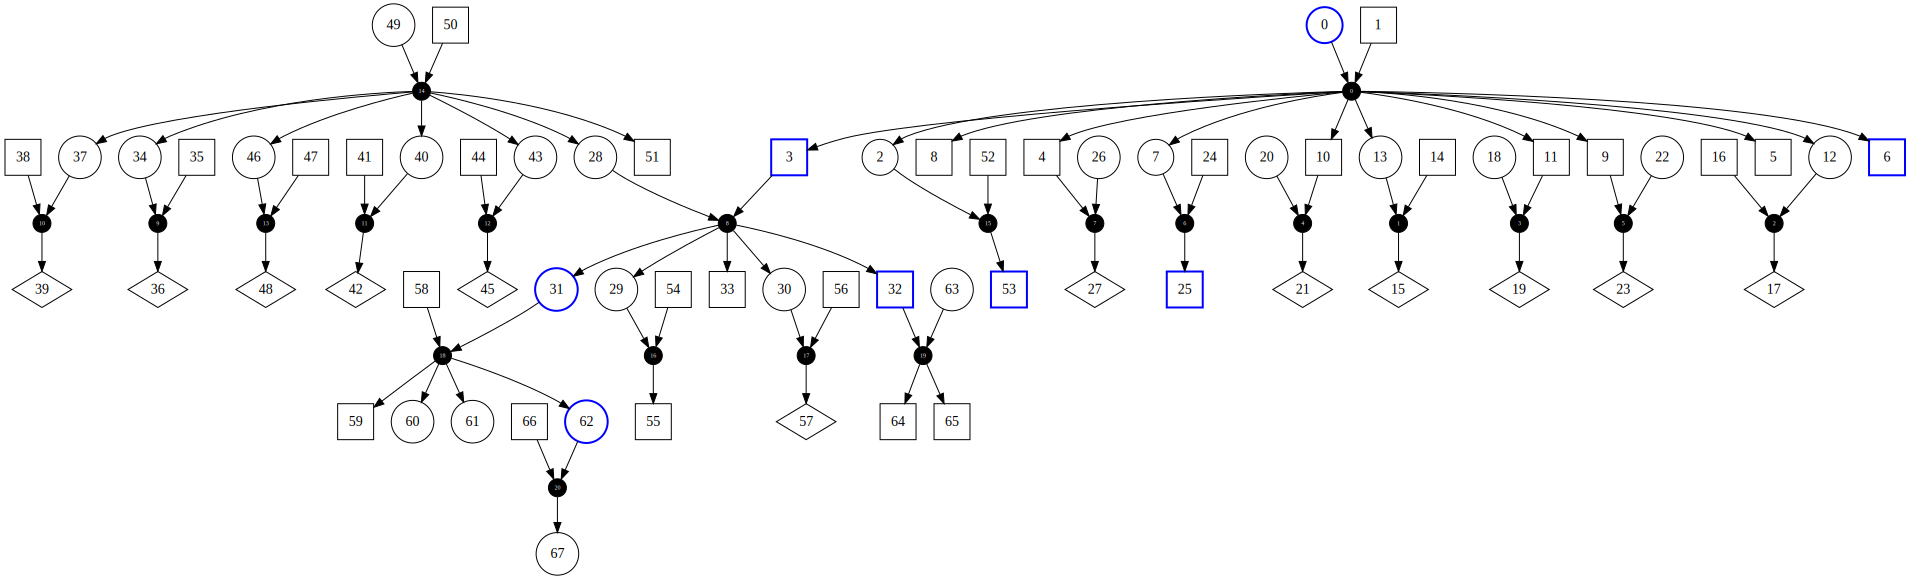

In [11]:
graph = DataGraph()
for parents, children in edges.values():
    graph.addEdge( parents=parents, children=children )
    
male_style = dict( shape='square' )
female_style = dict( shape='circle' )
unknown_style = dict( shape='diamond' )
affected_male_style = dict( shape='square', fontcolor='black', style='bold', color='blue' )
affected_female_style = dict( shape='circle', fontcolor='black', style='bold', color='blue' )
affected_unknown_style = dict( shape='diamond', fontcolor='black', style='bold', color='blue' )

unaffected_males = []
unaffected_females = []
unaffected_unknowns = []
affected_males = []
affected_females = []
affected_unknowns = []

for n in graph.nodes:
    person = pedigree.getPerson( index_map.inverse[ n ][ 0 ] )
    if( person.sex == 'male' ):
        if( person.affected == True ):
            affected_males.append( n )
        else:
            unaffected_males.append( n )
    elif( person.sex == 'female' ):
        if( person.affected == True ):
            affected_females.append( n )
        else:
            unaffected_females.append( n )
    else:
        if( person.affected == True ):
            affected_unknowns.append( n )
        else:
            unaffected_unknowns.append( n )            

styles = { 0: male_style, 1: female_style, 2: unknown_style, 3: affected_male_style, 4: affected_female_style, 5: affected_unknown_style }
node_to_style_key =       dict( [ ( n, 0 ) for n in unaffected_males ] )
node_to_style_key.update( dict( [ ( n, 1 ) for n in unaffected_females ] ) )
node_to_style_key.update( dict( [ ( n, 2 ) for n in unaffected_unknowns ] ) )
node_to_style_key.update( dict( [ ( n, 3 ) for n in affected_males ] ) )
node_to_style_key.update( dict( [ ( n, 4 ) for n in affected_females ] ) )
node_to_style_key.update( dict( [ ( n, 5 ) for n in affected_unknowns ] ) )
graph.draw( styles=styles, node_to_style_key=node_to_style_key )

# There are a few valid assumptions that can be made
- Can safely assume that a diagnosis is correct
    - Indicitive of possible latent states
    - Can rule out certain latent states (an affected individual in the AD case cannot have an "aa" latent state)
- Only one family branch will carry the disease
    - These are rare diseases
    - Implies that if a father and a son are affected in a family, the inheritance pattern cannot be XL